# Proyecto 04 Integrador - Series de Tiempo

Para este proyecto integrador, voy a emplear los métodos tradicionales (ARIMA, SARIMA y/o SARIMAX) para pronosticar los valores de cantidad de autos que pagarán en efectivo cada día por cada una de las estaciones de peaje.

La motivación de este trabajo es que a través de este pronóstico, la empresa pueda alocar mejor sus recursos humanos en estaciones con mayor flujo ese día.

Para este proyecto, tomaré como base todo el análisis realizado en el proyecto 03.

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

Para este trabajo utilizé como guía, el trabajo de Selva Prabhakaran publicado en machinelearningplus.com (https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import fbprophet as prophet
import matplotlib as matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
import matplotlib as mpl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import stattools
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
import re
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

### 1. Preparación del Dataset

In [2]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')
dataset = pd.concat([data_2019, data_2018, data_2017])

In [3]:
dataset.drop(columns = ['periodo','hora_inicio', 'sentido', 'tipo_vehiculo'], inplace = True)

In [4]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin','dia'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

In [5]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

In [6]:
#Unificamos la estación Dellepiane y Alberti
dataset.loc[(dataset["estacion"]=="Dellepiane Centro") | (dataset["estacion"]=="Dellepiane Liniers"),"estacion"]="Dellepiane"
dataset.loc[dataset["estacion"]=="Alberdi","estacion"]="Alberti"

In [7]:
#Filtramos por metodo de pago efectivo
dataset=dataset.loc[dataset["forma_pago"]=="EFECTIVO"]
dataset.drop(columns="forma_pago",inplace=True)

In [8]:
#Guardamos el dataset (ejecutado una sola vez)
dataset.to_csv("dataset_00.csv")

In [9]:
#Punto de backup
#dataset=pd.read_csv("dataset_00.csv")
dataset_illia=dataset.copy()
dataset_avellaneda=dataset.copy()
dataset_dellepiane=dataset.copy()
dataset_retiro=dataset.copy()
dataset_alberti=dataset.copy()

In [10]:
#Separamos 1 Dataset por cada estación
dataset_illia=dataset_illia.loc[dataset_illia["estacion"]=="Illia"]
dataset_avellaneda=dataset_avellaneda.loc[dataset_avellaneda["estacion"]=="Avellaneda"]
dataset_dellepiane=dataset_dellepiane.loc[dataset_dellepiane["estacion"]=="Dellepiane"]
dataset_retiro=dataset_retiro.loc[dataset_retiro["estacion"]=="Retiro"]
dataset_alberti=dataset_alberti.loc[dataset_alberti["estacion"]=="Alberti"]

In [11]:
dataset_illia.drop(columns="estacion",inplace=True)
dataset_avellaneda.drop(columns="estacion",inplace=True)
dataset_dellepiane.drop(columns="estacion",inplace=True)
dataset_retiro.drop(columns="estacion",inplace=True)
dataset_alberti.drop(columns="estacion",inplace=True)

In [12]:
dataset_illia=dataset_illia.groupby(by="fecha").sum()
dataset_avellaneda=dataset_avellaneda.groupby(by="fecha").sum()
dataset_dellepiane=dataset_dellepiane.groupby(by="fecha").sum()
dataset_retiro=dataset_retiro.groupby(by="fecha").sum()
dataset_alberti=dataset_alberti.groupby(by="fecha").sum()

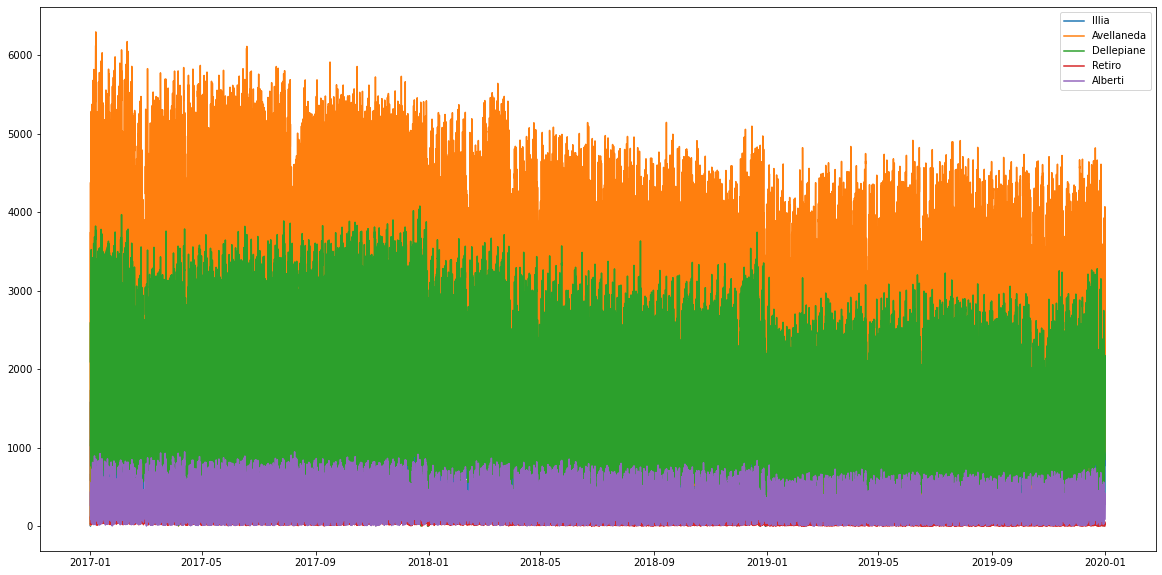

In [13]:
%matplotlib inline
plt.subplots(figsize=(20,10))
plt.plot(dataset_illia, label="Illia")
plt.plot(dataset_avellaneda, label="Avellaneda")
plt.plot(dataset_dellepiane, label="Dellepiane")
plt.plot(dataset_retiro, label="Retiro")
plt.plot(dataset_alberti, label="Alberti")
plt.legend()

In [14]:
#Resampleamos a frecuencia diaria
dataset_illia_d=dataset_illia.resample('D').sum()
dataset_avellaneda_d=dataset_avellaneda.resample('D').sum()
dataset_dellepiane_d=dataset_dellepiane.resample('D').sum()
dataset_retiro_d=dataset_retiro.resample('D').sum()
dataset_alberti_d=dataset_alberti.resample('D').sum()

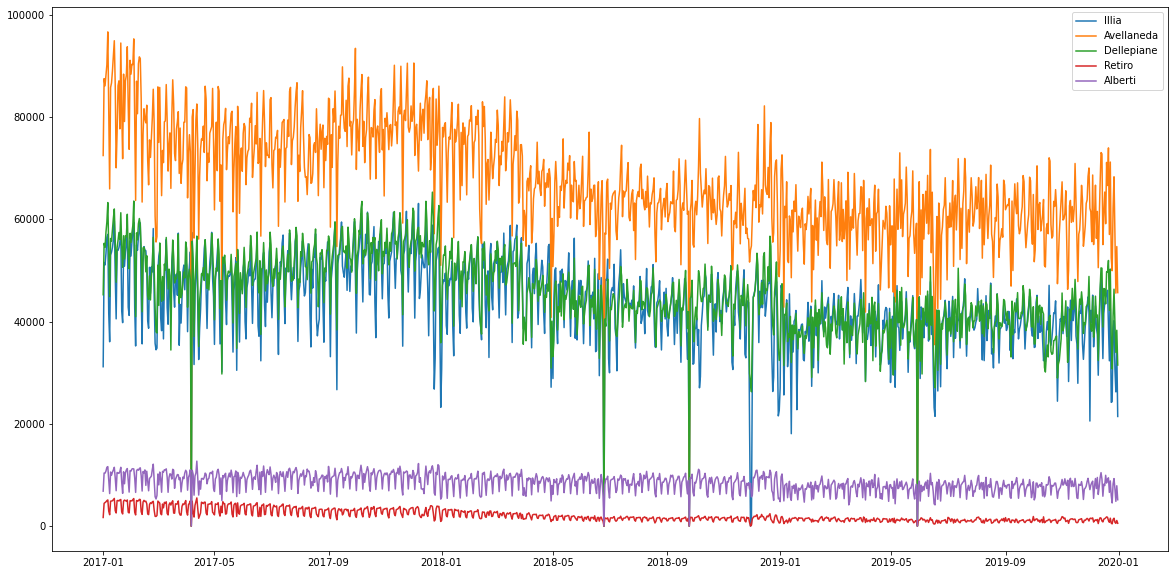

In [15]:
%matplotlib inline
plt.subplots(figsize=(20,10))
plt.plot(dataset_illia_d, label="Illia")
plt.plot(dataset_avellaneda_d, label="Avellaneda")
plt.plot(dataset_dellepiane_d, label="Dellepiane")
plt.plot(dataset_retiro_d, label="Retiro")
plt.plot(dataset_alberti_d, label="Alberti")
plt.legend()

#### Tratamiento de outliers o valores atípicos

In [16]:
# Vamos a interpolar los valores que se encuentren por debajo o por encima del percentil 2.5 o 97.5
dataset_illia_d.cantidad_pasos[(dataset_illia_d.cantidad_pasos < np.percentile(dataset_illia_d, 2.5)) | (dataset_illia_d.cantidad_pasos > np.percentile(dataset_illia_d, 97.5))] = np.nan
dataset_illia_d = dataset_illia_d.interpolate()

dataset_avellaneda_d.cantidad_pasos[(dataset_avellaneda_d.cantidad_pasos < np.percentile(dataset_avellaneda_d, 2.5)) | (dataset_avellaneda_d.cantidad_pasos > np.percentile(dataset_avellaneda_d, 97.5))] = np.nan
dataset_avellaneda_d = dataset_avellaneda_d.interpolate()

dataset_dellepiane_d.cantidad_pasos[(dataset_dellepiane_d.cantidad_pasos < np.percentile(dataset_dellepiane_d, 2.5)) | (dataset_dellepiane_d.cantidad_pasos > np.percentile(dataset_dellepiane_d, 97.5))] = np.nan
dataset_dellepiane_d = dataset_dellepiane_d.interpolate()

dataset_retiro_d.cantidad_pasos[(dataset_retiro_d.cantidad_pasos < np.percentile(dataset_retiro_d, 2.5)) | (dataset_retiro_d.cantidad_pasos > np.percentile(dataset_retiro_d, 97.5))] = np.nan
dataset_retiro_d = dataset_retiro_d.interpolate()

dataset_alberti_d.cantidad_pasos[(dataset_alberti_d.cantidad_pasos < np.percentile(dataset_alberti_d, 2.5)) | (dataset_alberti_d.cantidad_pasos > np.percentile(dataset_alberti_d, 97.5))] = np.nan
dataset_alberti_d = dataset_alberti_d.interpolate()



In [17]:
# Based on the code written in https://www.machinelearningplus.com/time-series/time-series-analysis-python/
def plot_trend_season(df):
    # Prepare data
    df['year'] = [d.year for d in df.index]
    df['month'] = [d.strftime('%b') for d in df.index]
    years = df['year'].unique()
    
    # Draw Plot
    print(df.name)
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='cantidad_pasos', data=df, ax=axes[0])
    sns.boxplot(x='month', y='cantidad_pasos', data=df.loc[~df.year.isin([2017, 2020]), :])
    
    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()
    
    df.drop(columns=["year","month"], inplace= True)

In [18]:
dataset_illia_d.name="dataset_illia_d"
dataset_avellaneda_d.name="dataset_avellaneda_d"
dataset_dellepiane_d.name="dataset_dellepiane_d"
dataset_retiro_d.name="dataset_retiro_d"
dataset_alberti_d.name="dataset_alberti_d"

dataset_illia_d


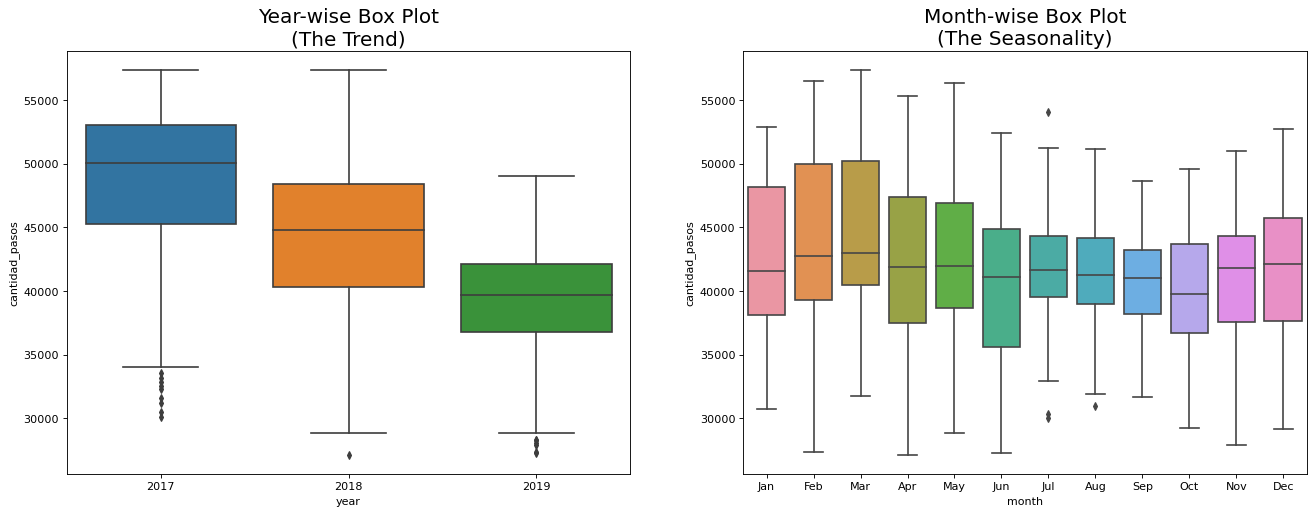

dataset_avellaneda_d


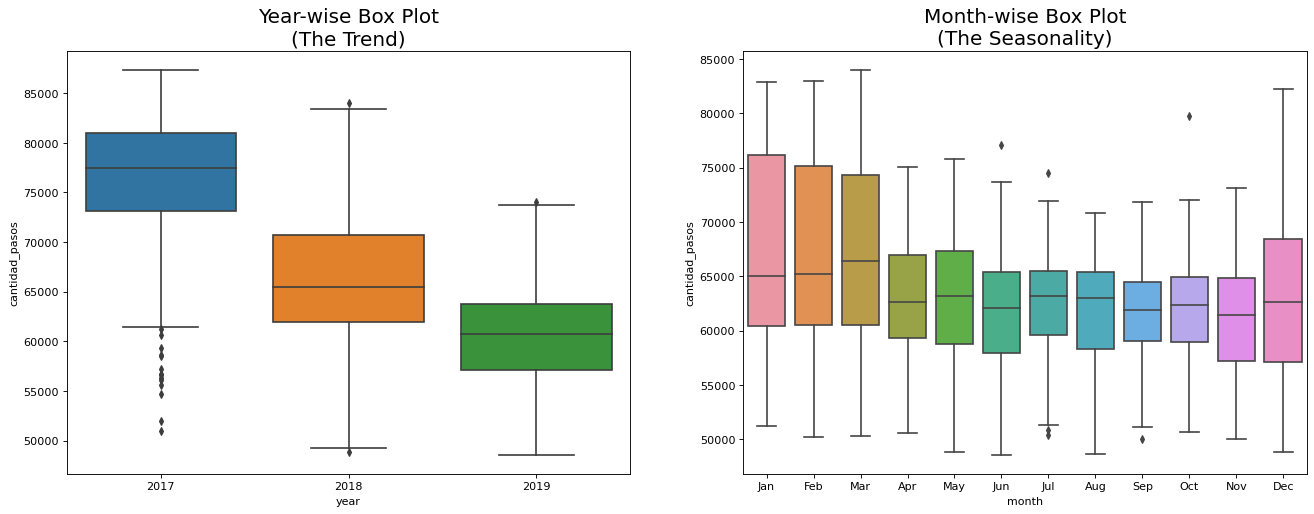

dataset_dellepiane_d


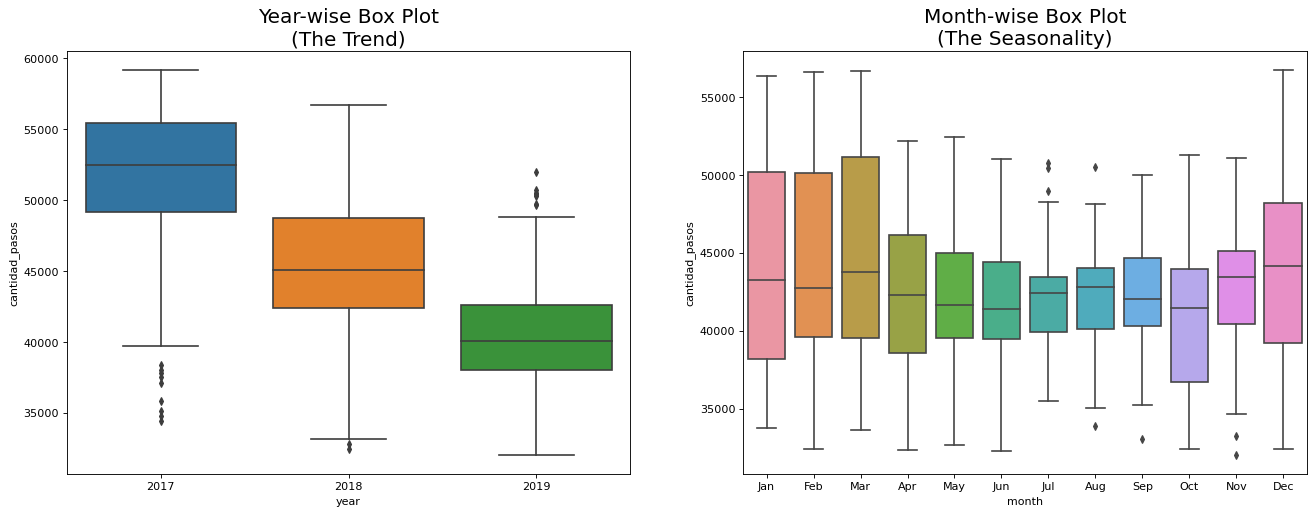

dataset_retiro_d


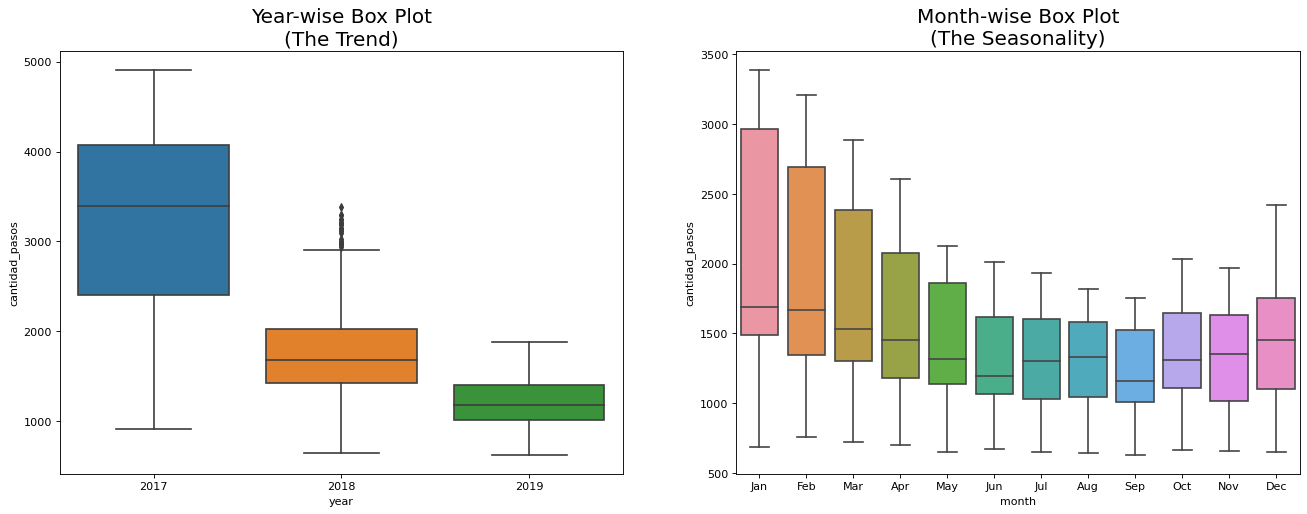

dataset_alberti_d


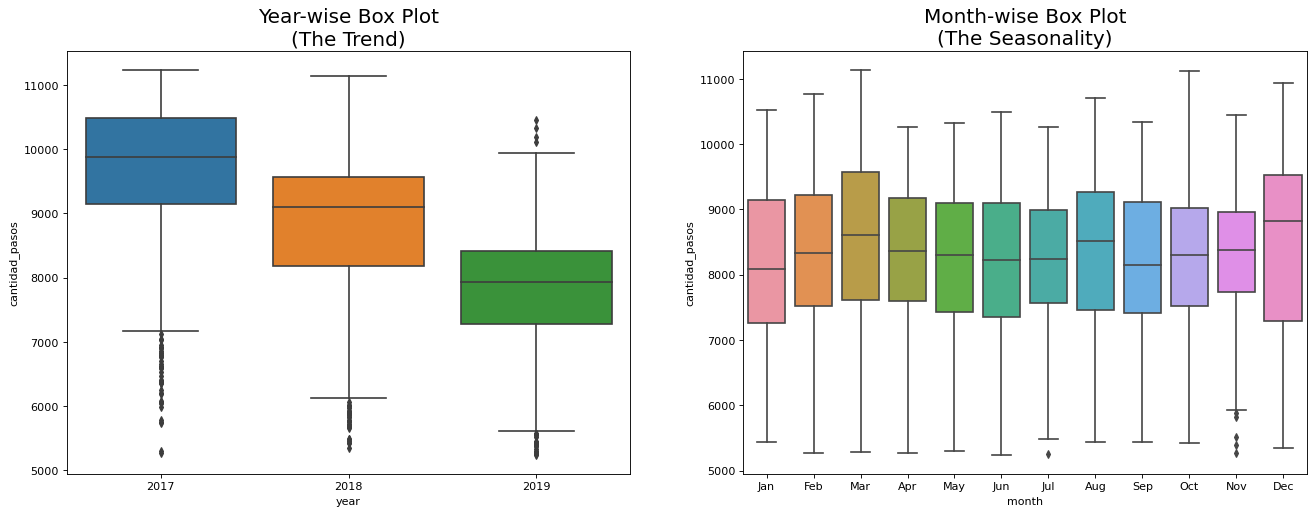

In [19]:
lista_datasets=[dataset_illia_d,dataset_avellaneda_d,dataset_dellepiane_d,dataset_retiro_d,dataset_alberti_d]
for df in lista_datasets:
    plot_trend_season(df)

Como puede verse en los gráficos anteriores, en todas las estaciones hay una estacionalidad no muy fuerte (en algunos más que en otra), pero sí una tendencia negativa presente. 

Para verificar si las series son estacionarias, haremos uso de la técnica Augmented Dickey Fuller test (ADF Test). En esta, la hipótesis nula es que la serie tiene una raiz única y que es no-estacionaria. Entonces, si el valor P en el test ADF es menor a 0.05, podemos rechazar la hipótesis nula confirmando (e un 95%) que la serie si es estacionaria.

También haremos uso del test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS Test) que verifica si la serie es estacionaria en la tendencia. Funciona de forma similar al ADF Test, pero su interpretacón es inversa. La hipótesis nula es que la serie es estacionaria, por lo tanto si obtenemos un valor p mayor a 0.05 podemos aceptar la hipótesis nula afirmando que la serie es estacionaria.

In [20]:
def test_stationarity(df):
    
    print(df.name)
    
    # ADF Test
    result = adfuller(df.cantidad_pasos.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
    
    # KPSS Test
    result = kpss(df.cantidad_pasos.values, regression='c')
    print('\nKPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
    print("---------------------------------------------------------------------------")

In [21]:
for df in lista_datasets:
    test_stationarity(df)

dataset_illia_d
ADF Statistic: -1.8176356201152861
p-value: 0.3717419131713388
Critical Values:
   1%, -3.4364533503600962
Critical Values:
   5%, -2.864234857527328
Critical Values:
   10%, -2.568204837482531

KPSS Statistic: 3.938352
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
---------------------------------------------------------------------------
dataset_avellaneda_d
ADF Statistic: -1.8644098992170248
p-value: 0.34898449377611407
Critical Values:
   1%, -3.4364533503600962
Critical Values:
   5%, -2.864234857527328
Critical Values:
   10%, -2.568204837482531

KPSS Statistic: 4.240154
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
---------------------------------------------------------------------------
dataset_dellepiane_d
ADF Statistic: -1.9648378059362193
p-value: 0.3022000342367381
Crit

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size

Podemos confirmar entonces que ninguna de las series es estacionaria y como todas tienen un componente tendencial y estacional es que usaremos el método SARIMA, llamado así por Seasonal ARIMA (Auto Regressive Integrated Moving Average).

Lo primero que tenemos que realizar es hacer las series de tiempo estacionarias. Para esto, lo más común es diferenciarla. Esto significa restar el valor anterior al valor actual. Dependiendo de la complejidad de la serie, puede requerirse varias diferenciaciones. El valor del parámetro "d" del método ARIMA hace referencia al menor número de diferenciaciones necesarias para hacer la serie estacionaria (o casi estacionaria). Esto puede verse haciendo un gráfico de autocorrelación (ACF) y se da cuando el gráfico alcanza un valor de 0 rápidamente. En los gráficos de ACF y PACF los intervalos de confianza se dibujan como un cono. Por defecto, se establece un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este área representan muy probablemente una correlación y no una casualidad estadística.

El método ARIMA tiene 3 componentes principales:
- p: orden o magnitud del componente auto regresivo (AR).

- q: orden o magnitud del componente promedio móvil (MA).

- d: magnitud requerida para hacer la serie de tiempo estacionaria.

Para encontrar el valor adecuado de d para cada serie iremos probando con distintos órdenes de diferenciación y viendo el gráfico de autocorrelación.

In [22]:
def test_d(df):
    print(df.name)
    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
    # Original Series
    fig, axes = plt.subplots(3, 2, sharex=False)
    axes[0, 0].plot(df.cantidad_pasos); axes[0, 0].set_title('Original Series'); axes[0,0].tick_params(axis='x', labelrotation = 45)
    plot_acf(df.cantidad_pasos, ax=axes[0, 1])
    
    # 1st Differencing
    axes[1, 0].plot(df.cantidad_pasos.diff()); axes[1, 0].set_title('1st Order Differencing'); axes[1,0].tick_params(axis='x', labelrotation = 45)
    plot_acf(df.cantidad_pasos.diff().dropna(), ax=axes[1, 1])
    
    # 2nd Differencing
    axes[2, 0].plot(df.cantidad_pasos.diff().diff()); axes[2, 0].set_title('2nd Order Differencing'); axes[2,0].tick_params(axis='x', labelrotation = 45)
    plot_acf(df.cantidad_pasos.diff().diff().dropna(), ax=axes[2, 1])
    
    plt.tight_layout()
    plt.show()

dataset_illia_d


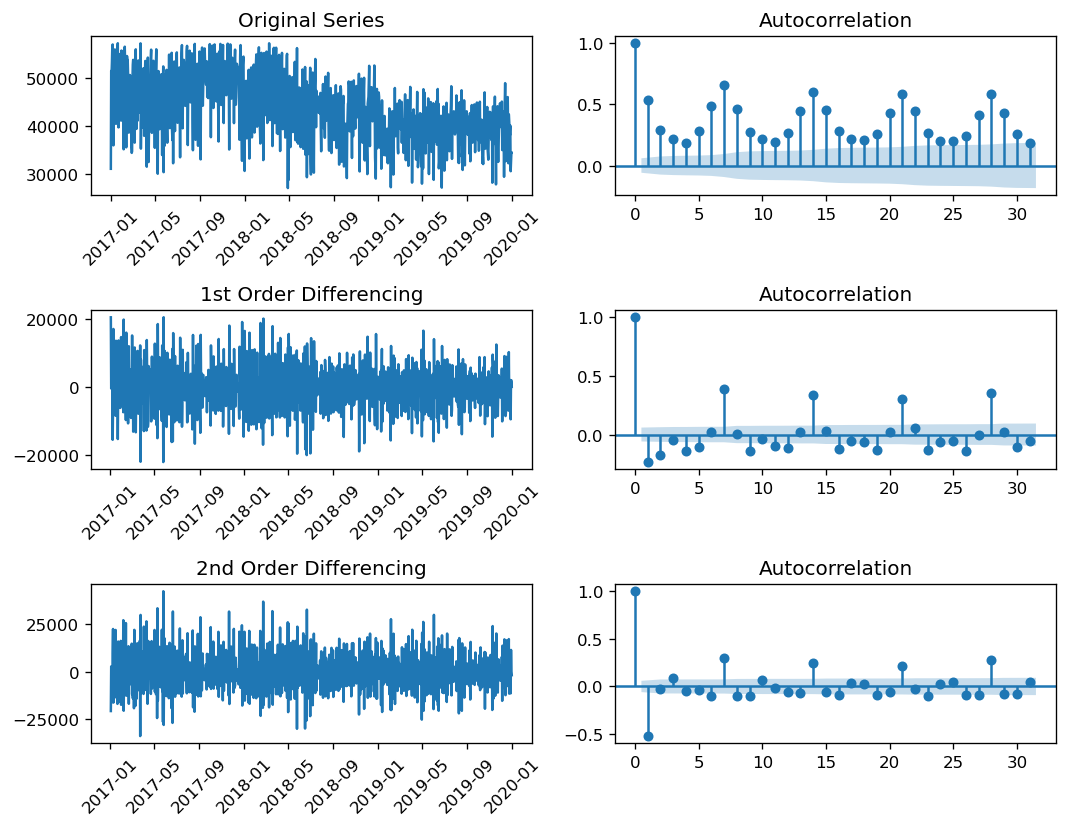

dataset_avellaneda_d


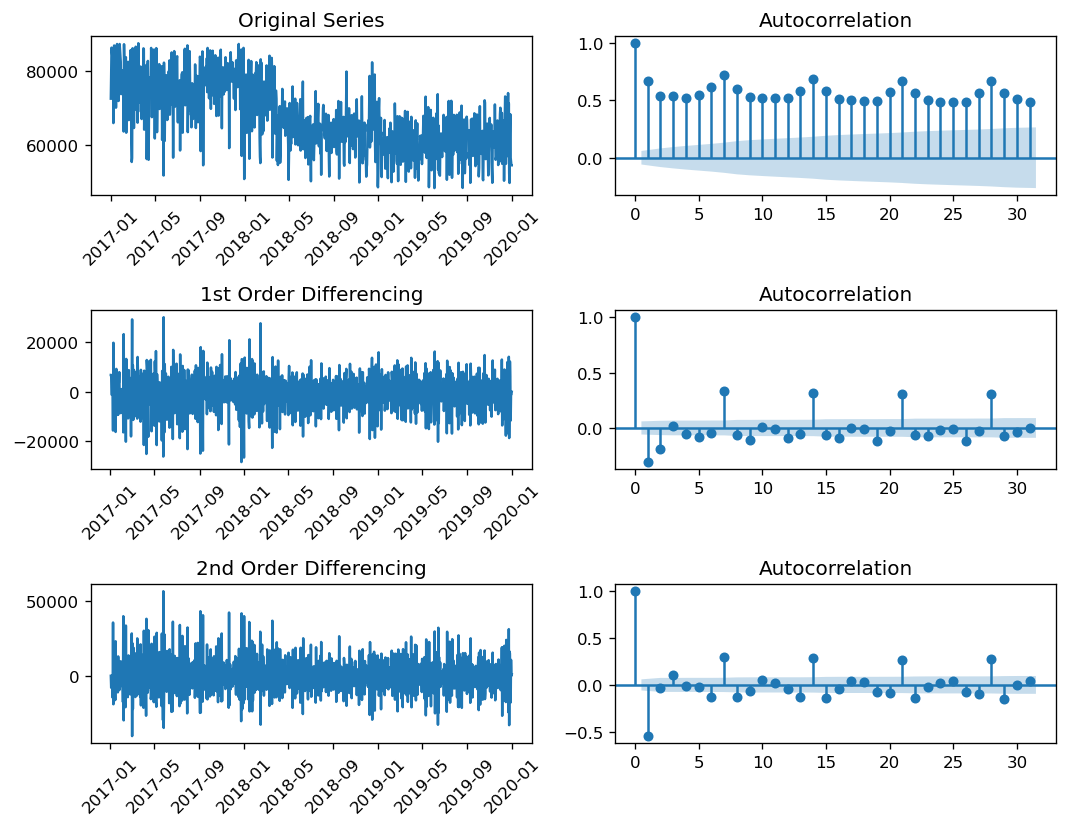

dataset_dellepiane_d


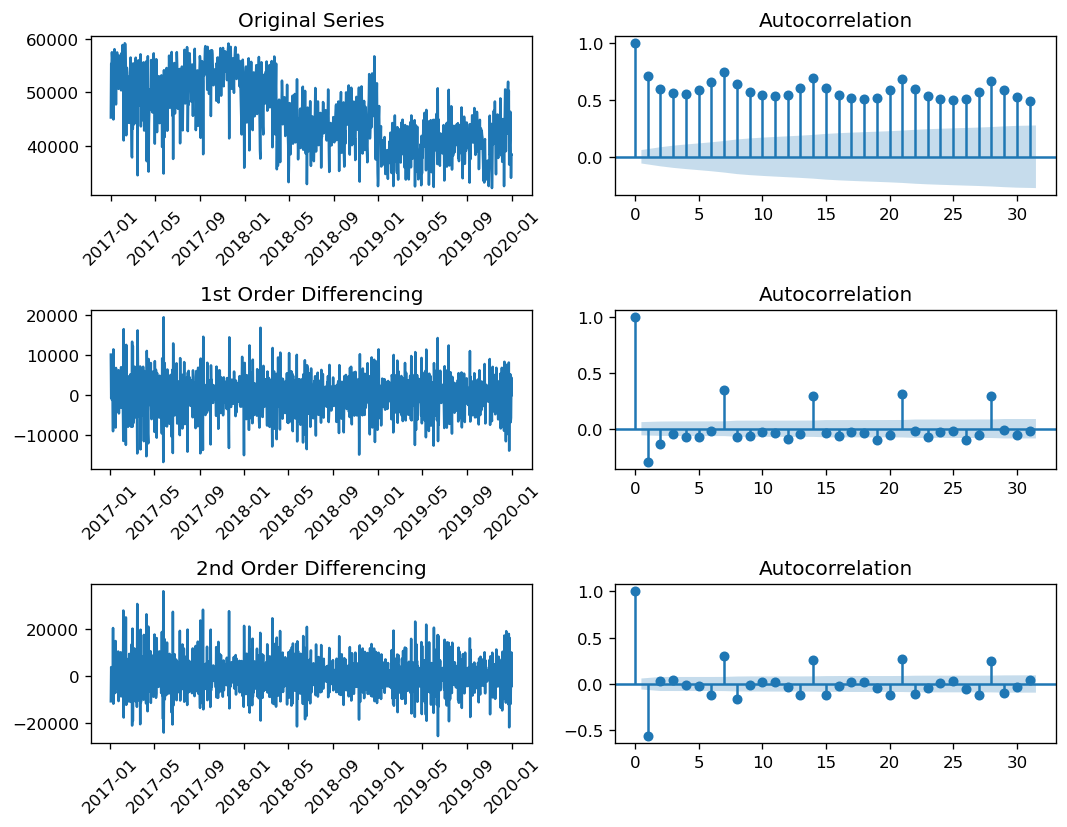

dataset_retiro_d


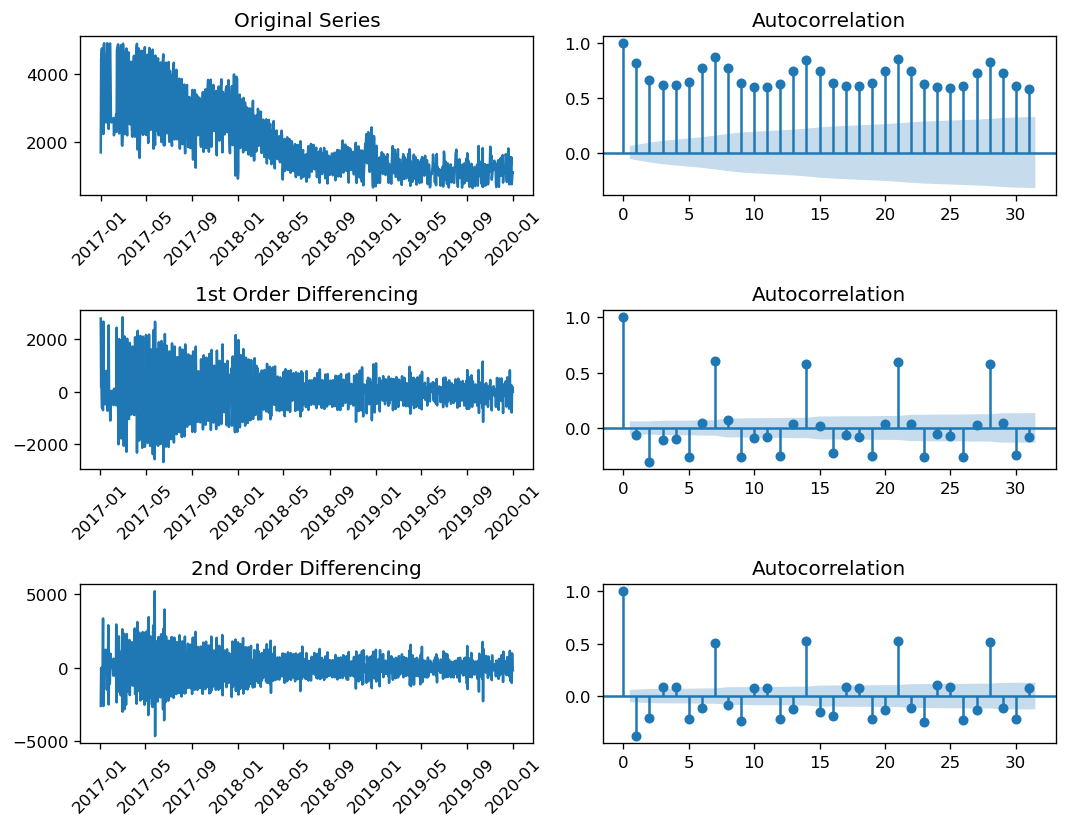

dataset_alberti_d


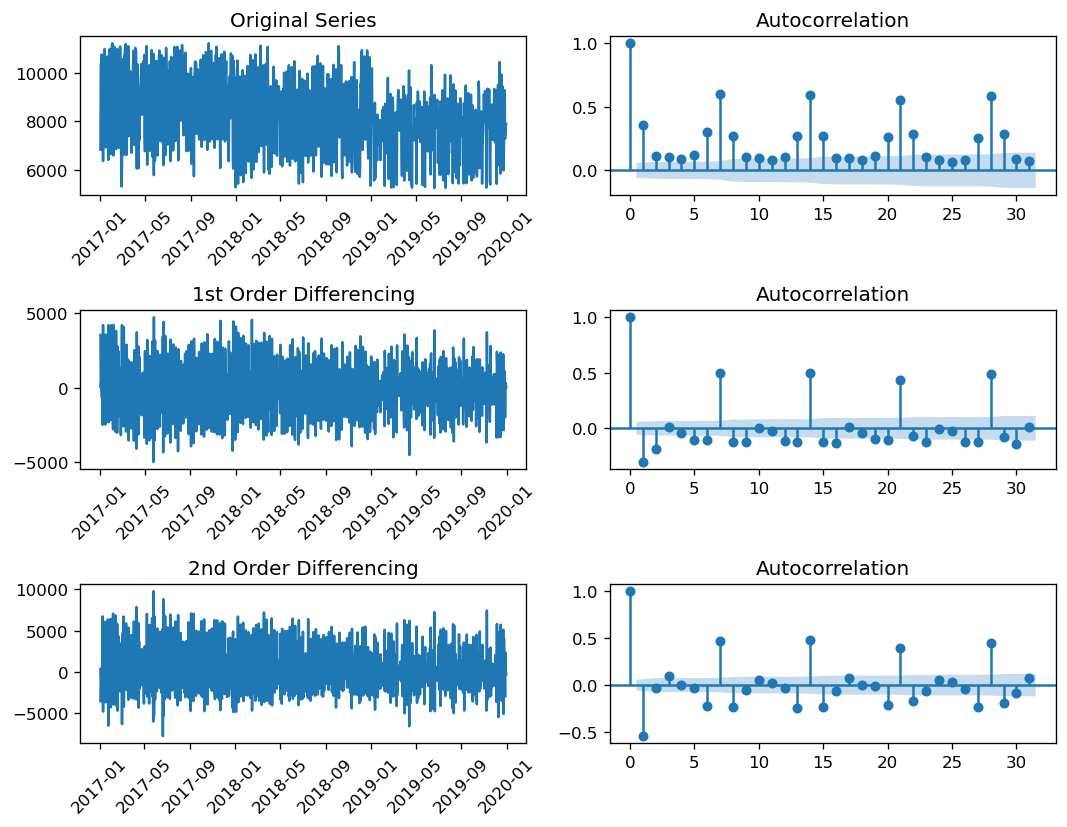

In [23]:
for df in lista_datasets:
    test_d(df)

Como puede apreciarse en todos los casos, el orden de diferenciación 1 es suficiente para conseguir una serie casi estacionaria y no sobre-diferenciar la serie.

Ya habiendo determinado el parámetro d, es momento de identificar el valor que tomará el parámetro autoregresivo p. Para esto haremos uso del gráfico de autocorrelación parcial conocido como PACF.
Una autocorrelación parcial es un resumen de la relación entre una observación en una serie temporal con observaciones en etapas anteriores, sin tener en cuenta las relaciones de las observaciones intermedias.
La autocorrelación parcial en el lag k es la correlación que resulta después de eliminar el efecto de cualquier correlación debida a los términos en lags intermedios.

In [24]:
def func_plot_pacf(df):
    print(df.name)
    plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

    fig, axes = plt.subplots(1, 2, sharex=False)
    axes[0].plot(df.cantidad_pasos.diff()); axes[0].set_title('1st Differencing'); axes[0].tick_params(axis='x', labelrotation = 45)
    #axes[1].set(ylim=(0,5))
    plot_pacf(df.cantidad_pasos.diff().dropna(), ax=axes[1])
    pacf_result=pd.DataFrame(pacf(df.cantidad_pasos.diff().dropna()))
    pacf_result.columns=["cantidad_pasos"]
    pacf_result["cantidad_pasos"]=pacf_result["cantidad_pasos"].abs()
    pacf_result=pacf_result.sort_values(by="cantidad_pasos", ascending=False).head(10)
    plt.show()
    print(pacf_result)

dataset_illia_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


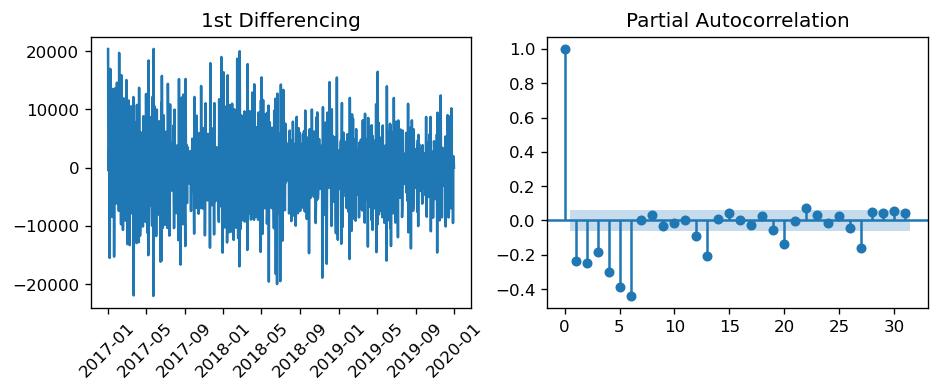

    cantidad_pasos
0         1.000000
6         0.439795
5         0.385376
4         0.297790
2         0.247751
1         0.235177
13        0.206715
3         0.180915
27        0.157929
20        0.138098
dataset_avellaneda_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


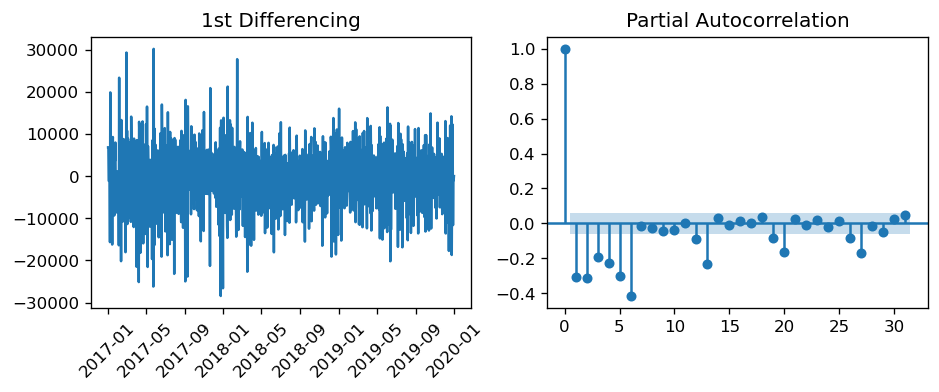

    cantidad_pasos
0         1.000000
6         0.416658
2         0.312932
1         0.308600
5         0.304036
13        0.232469
4         0.227848
3         0.193524
27        0.168057
20        0.165547
dataset_dellepiane_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


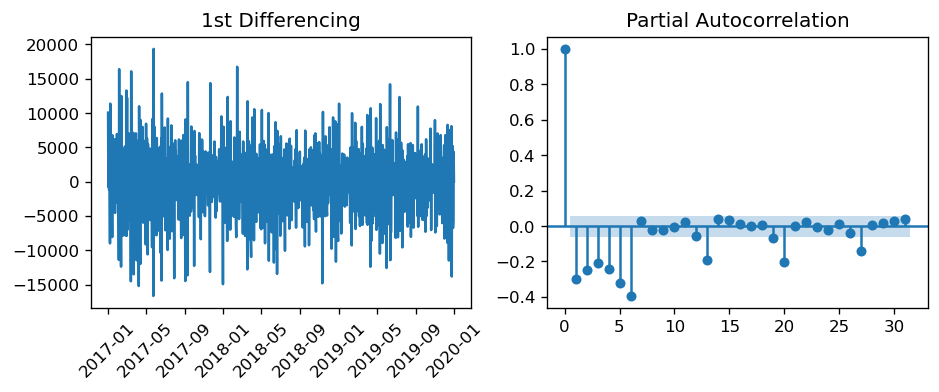

    cantidad_pasos
0         1.000000
6         0.394597
5         0.318866
1         0.299494
2         0.249977
4         0.243491
3         0.207228
20        0.204849
13        0.191246
27        0.142095
dataset_retiro_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


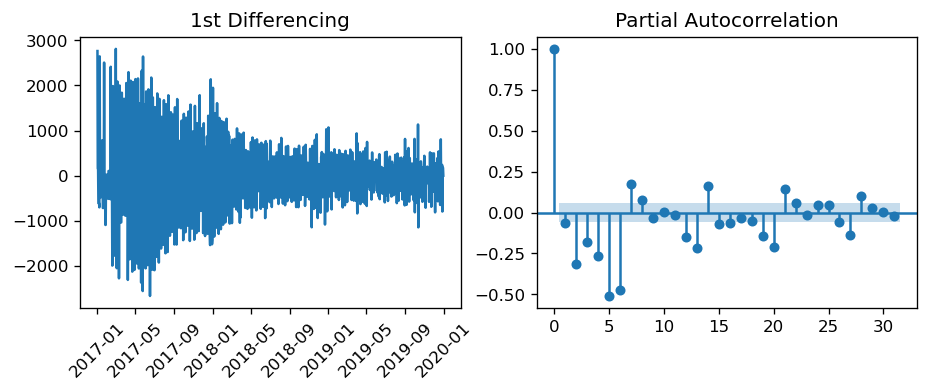

    cantidad_pasos
0         1.000000
5         0.510075
6         0.473304
2         0.314387
4         0.263179
13        0.217505
20        0.208648
40        0.182640
3         0.177262
7         0.173221
dataset_alberti_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


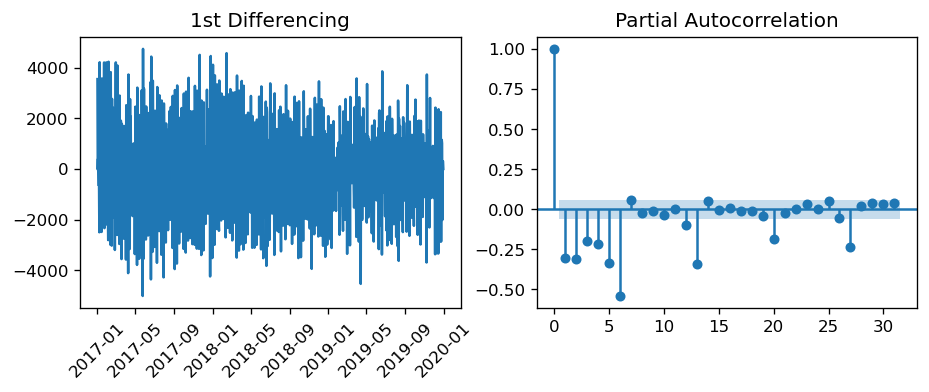

    cantidad_pasos
0         1.000000
6         0.540435
13        0.341944
5         0.332752
2         0.311435
1         0.304516
27        0.233175
4         0.219363
3         0.195314
20        0.188386


In [25]:
for df in lista_datasets:
    func_plot_pacf(df)

Con base a los resultados anteriores tomamos el mayor valor de autocorrelación parcial de cada serie:
- Illia: 6
- Avellandea: 6
- Dellepiane: 6
- Retiro: 5
- Alberti: 6

Ahora hallaremos el valor de q que hace referencia al parámetro de media móvil. Básicamente un parámetro de media móvil es el error del pronóstico retardado (teniendo en cuenta valores pasados). Para encontrarlo haremos uso del gráfico de autocorrelación ACF. El ACF indica cuántos términos de media móvil son necesarios para eliminar cualquier autocorrelación en la serie estacionaria.

In [26]:
def func_plot_acf(df):
    print(df.name)
    plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
    fig, axes = plt.subplots(1, 2, sharex=False)
    axes[0].plot(df.cantidad_pasos.diff()); axes[0].set_title('1st Differencing'); axes[0].tick_params(axis='x', labelrotation = 45)
    #axes[1].set(ylim=(0,5))
    plot_acf(df.cantidad_pasos.diff().dropna(), ax=axes[1])
    acf_result=pd.DataFrame(acf(df.cantidad_pasos.diff().dropna()))
    acf_result.columns=["cantidad_pasos"]
    acf_result["cantidad_pasos"]=acf_result["cantidad_pasos"].abs()
    acf_result=acf_result.sort_values(by="cantidad_pasos", ascending=False).head(10)
    plt.show()
    print(acf_result)

dataset_illia_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


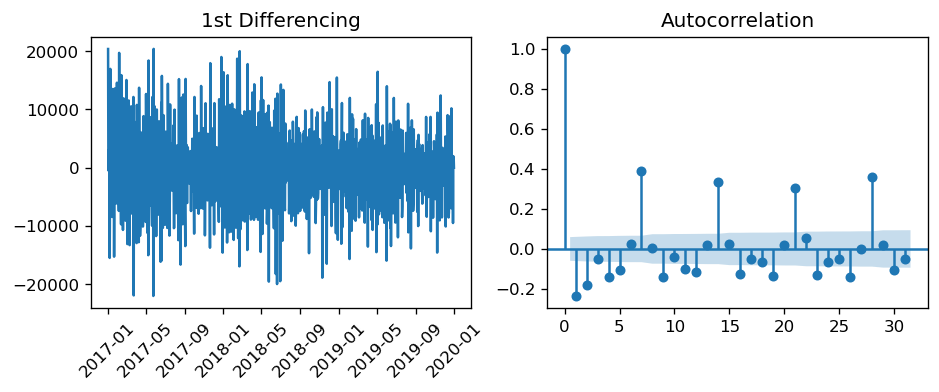

    cantidad_pasos
0         1.000000
7         0.391520
28        0.357206
35        0.347074
14        0.333633
21        0.305712
1         0.234962
2         0.178413
37        0.153191
26        0.142452
dataset_avellaneda_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


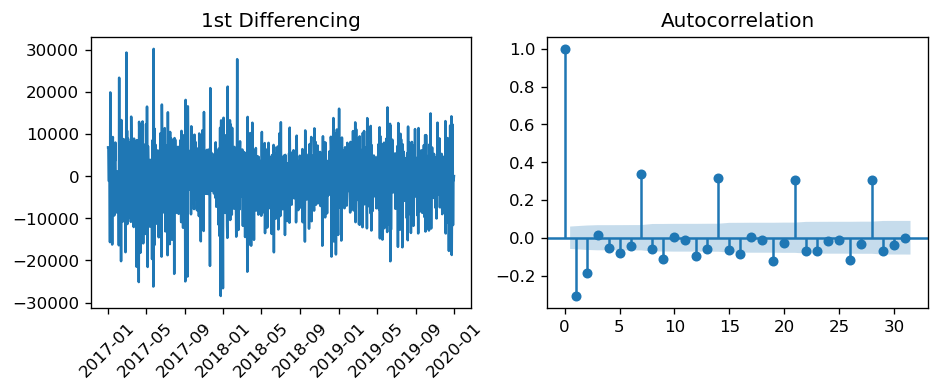

    cantidad_pasos
0         1.000000
7         0.335804
14        0.318473
1         0.308318
21        0.305422
28        0.305191
35        0.294770
2         0.187553
40        0.137588
19        0.121651
dataset_dellepiane_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


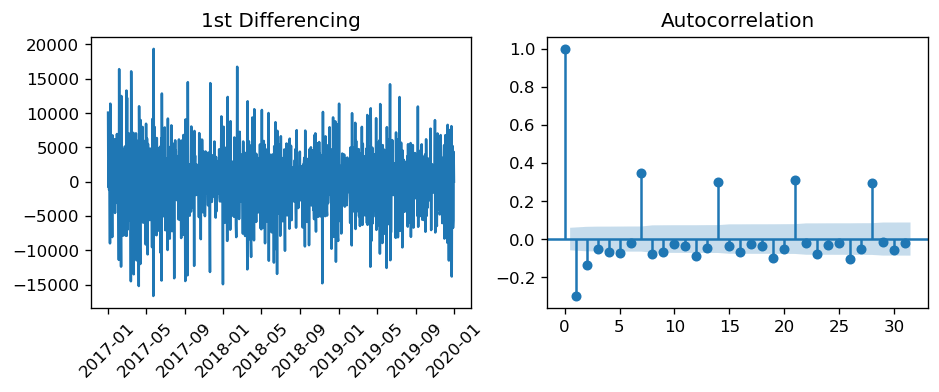

    cantidad_pasos
0         1.000000
7         0.346233
21        0.310503
35        0.301535
1         0.299220
14        0.297451
28        0.293921
2         0.137606
37        0.127059
40        0.109293
dataset_retiro_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


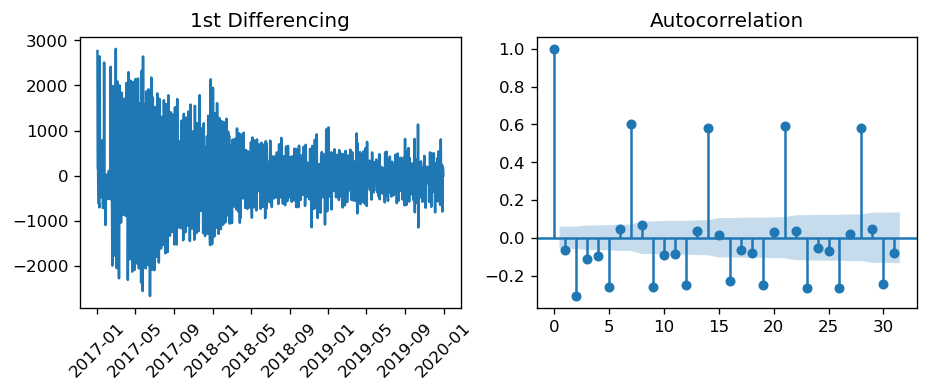

    cantidad_pasos
0         1.000000
7         0.600344
21        0.592148
28        0.580841
35        0.580366
14        0.578990
2         0.308223
40        0.297829
23        0.266302
26        0.265412
dataset_alberti_d


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


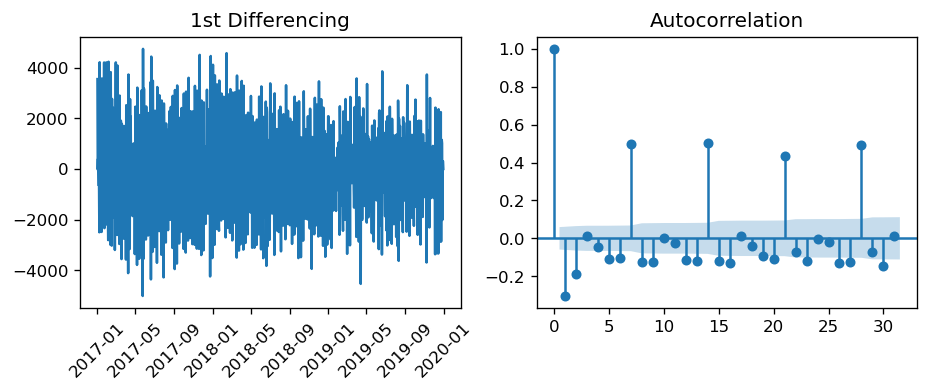

    cantidad_pasos
0         1.000000
14        0.502040
7         0.496562
28        0.492019
35        0.468909
21        0.434709
1         0.304237
2         0.189479
30        0.145275
37        0.143427


In [27]:
for df in lista_datasets:
    func_plot_acf(df)

Con base a los resultados anteriores tomamos el mayor valor de autocorrelación de cada serie:
- Illia: 7
- Avellandea: 7
- Dellepiane: 7
- Retiro: 7
- Alberti: 14

Ahora que ya tenemos determinados los valores de p,q y d para cada serie, procederemos a ajustar el modelo de ARIMA para cada una de ellas.

Valores p
- Illia: 6
- Avellandea: 6
- Dellepiane: 6
- Retiro: 5
- Alberti: 6

Valor d: 1

Valores q
- Illia: 7
- Avellandea: 7
- Dellepiane: 7
- Retiro: 7
- Alberti: 14


In [28]:
def test_arima(df,p,d,q):
    #print(df.name)
    
    model = ARIMA(df.cantidad_pasos, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())
    
    # Plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    # Actual vs Fitted
    df.cantidad_pasos.plot(label="Original")
    model_fit.predict(dynamic=False).plot(label="fitted")
    plt.legend()
    plt.show()

#### Separación de datos en train y test

In [29]:
#Tomaremos el primer 80% como datos de entrenamiento y el restante 20% como datos de test.
cantidad_train=round(0.8*len(dataset_illia_d))

In [30]:
illia_train=dataset_illia_d.iloc[:cantidad_train]
illia_test=dataset_illia_d.iloc[cantidad_train:]

avellaneda_train=dataset_avellaneda_d.iloc[:cantidad_train]
avellaneda_test=dataset_avellaneda_d.iloc[cantidad_train:]

dellepiane_train=dataset_dellepiane_d.iloc[:cantidad_train]
dellepiane_test=dataset_dellepiane_d.iloc[cantidad_train:]

retiro_train=dataset_retiro_d.iloc[:cantidad_train]
retiro_test=dataset_retiro_d.iloc[cantidad_train:]

alberti_train=dataset_alberti_d.iloc[:cantidad_train]
alberti_test=dataset_alberti_d.iloc[cantidad_train:]

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                  876
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -8609.784
Date:                Sun, 07 Feb 2021   AIC                          17247.569
Time:                        20:02:35   BIC                          17314.408
Sample:                    01-01-2017   HQIC                         17273.136
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9687      0.035    -27.936      0.000      -1.037      -0.901
ar.L2         -0.9716      0.017    -55.820      0.000      -1.006      -0.937
ar.L3         -0.9717      0.032    -29.933      0.0

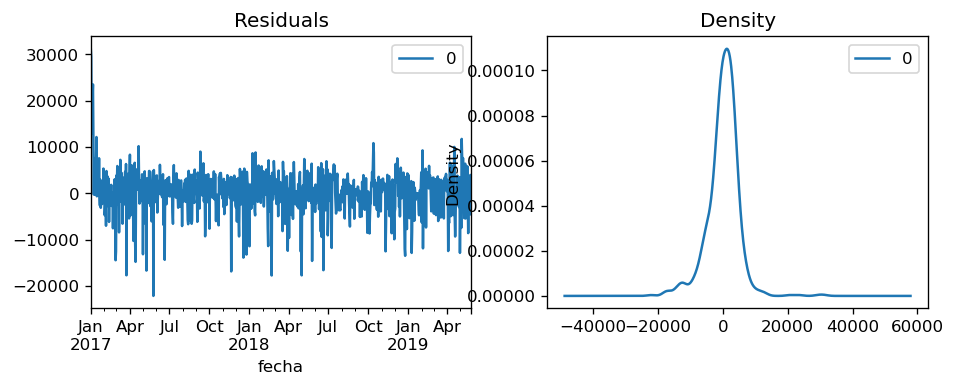

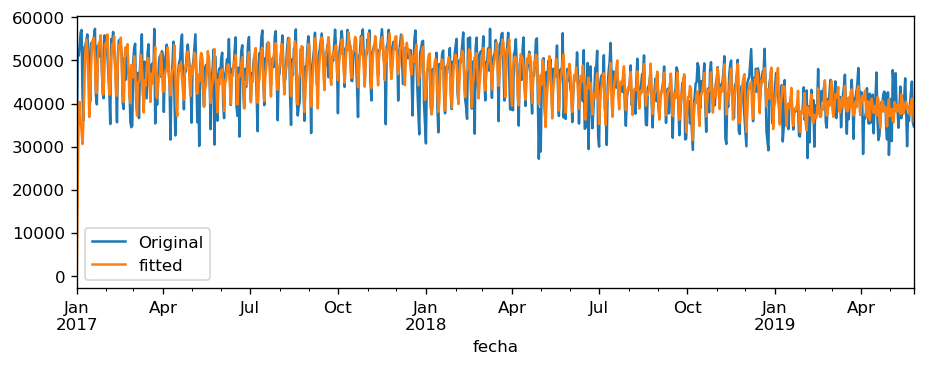

In [31]:
#### Illia
test_arima(illia_train,6,1,7)

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                  876
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -8795.098
Date:                Sun, 07 Feb 2021   AIC                          17618.196
Time:                        20:02:40   BIC                          17685.035
Sample:                    01-01-2017   HQIC                         17643.763
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0640      0.011    -93.260      0.000      -1.086      -1.042
ar.L2         -0.9299      0.016    -56.742      0.000      -0.962      -0.898
ar.L3         -1.0626      0.020    -53.210      0.0

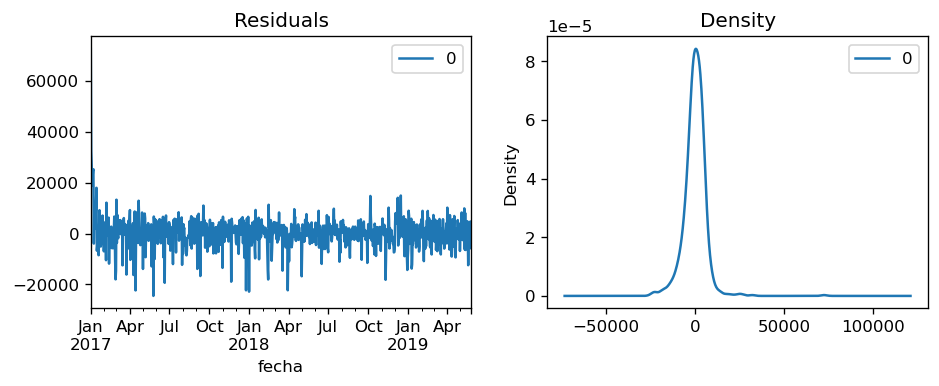

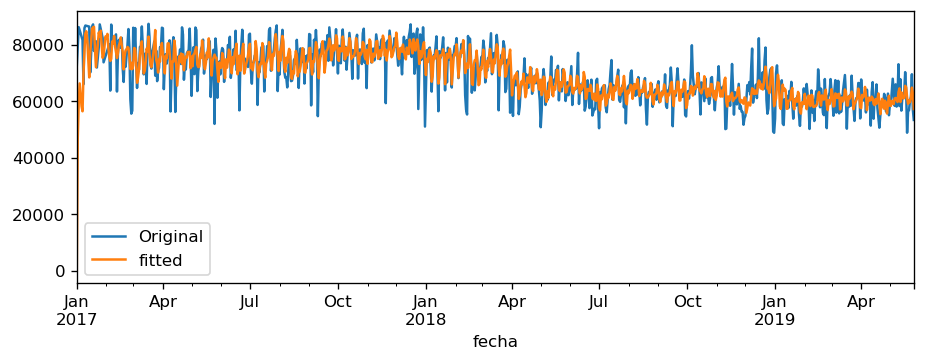

In [32]:
#### Avellaneda
test_arima(avellaneda_train,6,1,7)

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                  876
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -8433.177
Date:                Sun, 07 Feb 2021   AIC                          16894.354
Time:                        20:02:48   BIC                          16961.193
Sample:                    01-01-2017   HQIC                         16919.921
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9856      0.014    -69.150      0.000      -1.014      -0.958
ar.L2         -0.9814      0.008   -116.290      0.000      -0.998      -0.965
ar.L3         -0.9849      0.013    -75.371      0.0

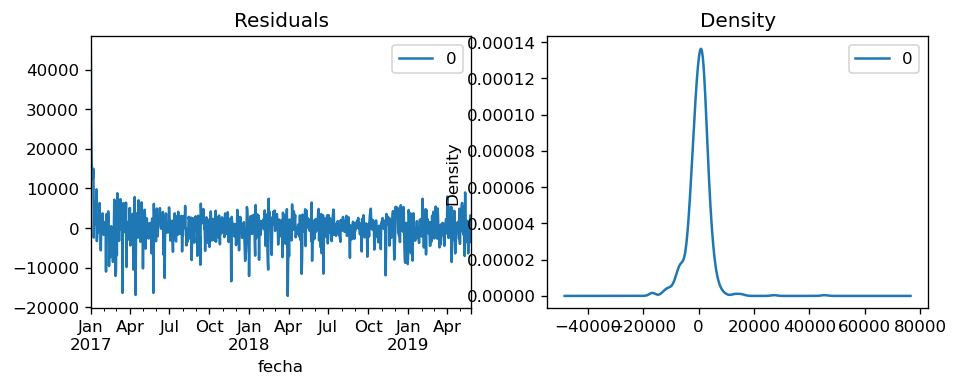

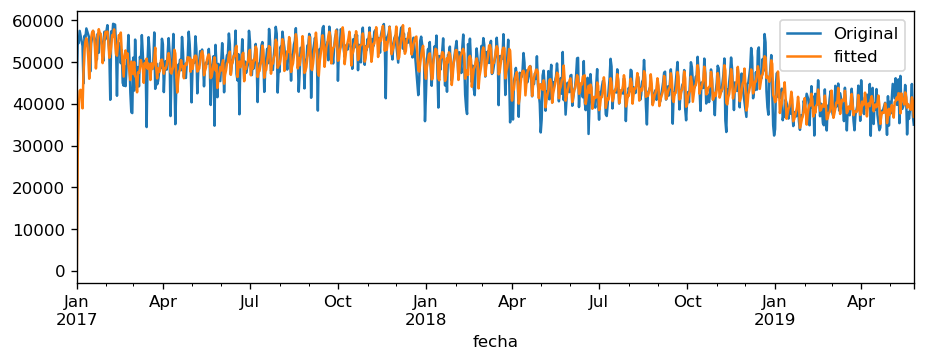

In [33]:
#### Dellepiane
test_arima(dellepiane_train,6,1,7)

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                  876
Model:                 ARIMA(5, 1, 7)   Log Likelihood               -6535.027
Date:                Sun, 07 Feb 2021   AIC                          13096.053
Time:                        20:02:53   BIC                          13158.118
Sample:                    01-01-2017   HQIC                         13119.795
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1622      0.089     -1.826      0.068      -0.336       0.012
ar.L2         -0.6688      0.071     -9.398      0.000      -0.808      -0.529
ar.L3         -0.5835      0.128     -4.571      0.0

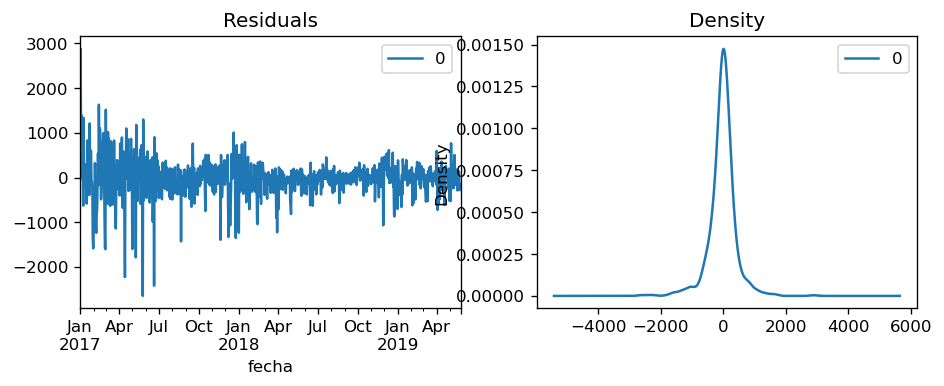

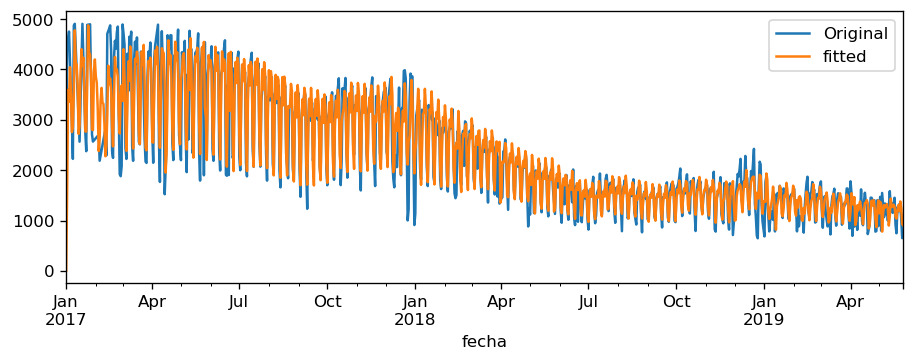

In [34]:
#### Retiro
test_arima(retiro_train,5,1,7)

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                  876
Model:                ARIMA(6, 1, 14)   Log Likelihood               -7253.777
Date:                Sun, 07 Feb 2021   AIC                          14549.553
Time:                        20:03:02   BIC                          14649.812
Sample:                    01-01-2017   HQIC                         14587.905
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9822      0.010   -100.437      0.000      -1.001      -0.963
ar.L2         -0.9844      0.008   -129.473      0.000      -0.999      -0.970
ar.L3         -0.9804      0.010   -100.573      0.0

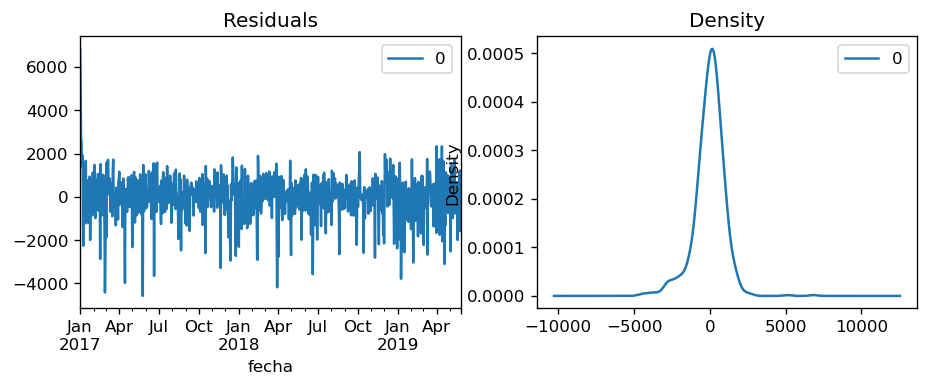

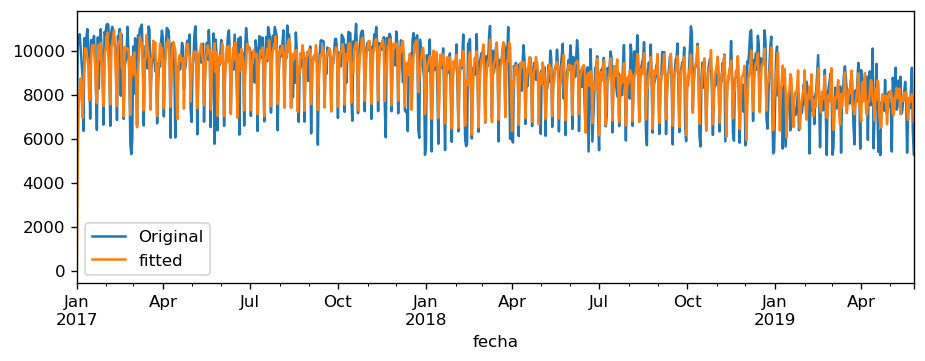

In [35]:
#### Alberti
test_arima(alberti_train,6,1,14)

Si bien no obtuvimos malos resultados con los parámetros elegidos a partir de nuetro análisis y criterio, nos ayudaremos con la función auto_arima de la librería pmdarima para encontrar los parámetros óptimos para cada serie.

Para poder comparar distintos modelos ARIMA con distintos parámetros, haremos uso de la métrica AIC (Criterio de información de Akaike). Este es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.Dado un conjunto de modelos candidatos para los datos, el modelo preferido es el que tiene el valor mínimo en el AIC. Por lo tanto AIC no solamente recompensa la bondad de ajuste, sino también incluye una penalidad, que es una función creciente del número de parámetros estimados. Esta penalización desalienta el sobreajuste (aumentando el número de parámetros libres en el modelo mejora la bondad del ajuste, sin importar el número de parámetros libres en el proceso de generación de datos).


In [36]:
model_illia = pm.auto_arima(illia_train.cantidad_pasos, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=7,              # frequency of series (daily)
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_illia.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=17534.672, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17932.437, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17484.265, Time=0.92 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=17584.168, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=21285.668, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=17683.061, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=17470.212, Time=3.10 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=17424.771, Time=2.43 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=17478.172, Time=1.11 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=17444.879, Time=1.36 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=17616.400, Time=2.85 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=17517.798, Time=2.99 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=17409.989, Time=2.52 sec
 ARIMA(1,0,1)(1,0,1)[7] i

Comparando los AIC del modelo que propusimos nosotros (6,1,7) no se nota una mejoría respecto de nuestro AIC anterior de 17247, así que decidimos quedarnos con esta primer configuración.

In [37]:
model_avellaneda = pm.auto_arima(avellaneda_train.cantidad_pasos, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=7,              # frequency of series (daily)
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_avellaneda.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=17808.321, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=18449.512, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17763.978, Time=0.71 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=18036.769, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=22035.973, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=17958.803, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=17724.412, Time=2.59 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=17789.864, Time=2.14 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=17764.636, Time=0.83 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=18443.794, Time=2.37 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=17696.466, Time=5.34 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=17749.280, Time=1.04 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=17877.865, Time=2.86 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,0)(2,0,0)[7] in

Comparando los AIC del modelo que propusimos nosotros (6,1,7) y las que obtuvimos con autoarima vemos una leve mejoría de 17618 a 17523, por lo que decidimos quedarnos con esta configuración.

In [38]:
model_dellepiane = pm.auto_arima(dellepiane_train.cantidad_pasos, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=7,              # frequency of series (daily)
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_dellepiane.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=17102.172, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17839.787, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17061.482, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=17390.982, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=21352.550, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=17263.905, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=17033.457, Time=2.72 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=17036.121, Time=2.53 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=17061.753, Time=0.75 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=17827.838, Time=2.14 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=17007.957, Time=5.64 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=17044.578, Time=0.90 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=17076.777, Time=2.82 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=17036.148, Time=0.93 sec
 ARIMA(3,0,0)(2,0,0

Comparando los AIC del modelo que propusimos nosotros (6,1,7) hay una leve mejoría de 16894 a 16864, así que decidimos quedarnos con esta configuración.

In [39]:
model_retiro = pm.auto_arima(retiro_train.cantidad_pasos, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=7,              # frequency of series (daily)
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_retiro.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=13647.968, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14773.630, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=13336.823, Time=1.06 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13846.305, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16243.288, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=13922.701, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=13191.777, Time=2.05 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=13299.419, Time=1.93 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13204.291, Time=1.33 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=13662.205, Time=2.17 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=13205.825, Time=2.45 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=13241.980, Time=1.75 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=13292.421, Time=1.61 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(1,0,0)(2,0,0)[7]  

Comparando los AIC del modelo que propusimos nosotros (5,1,7) no hay mejoría respecto de nuestro valor de AIC previo 13096, por lo que decidimos quedarnos con la configuración anterior.

In [40]:
model_alberti = pm.auto_arima(alberti_train.cantidad_pasos, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=14, # maximum p and q
                      m=7,              # frequency of series (daily)
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_alberti.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=14971.621, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=15279.224, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14981.913, Time=0.62 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14970.406, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=18431.858, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=15176.385, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=14840.922, Time=0.68 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=14843.698, Time=1.89 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=14912.914, Time=0.76 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=14840.610, Time=0.94 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=14840.295, Time=1.03 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   :

Comparando los AIC del modelo que propusimos nosotros (6,1,14) no vemos mejoría respecto al valor anterior de 14549, así que decidimos quedarnos con la configuración anterior.

In [41]:
# Dejamos definidos los modelos

model_illia=ARIMA(illia_train.cantidad_pasos, order=(6,1,7))
model_illia_fit = model_illia.fit()

model_avellaneda=ARIMA(avellaneda_train.cantidad_pasos, order=(6,0,0), seasonal_order=(1,0,1,7))
model_avellaneda_fit = model_avellaneda.fit()

model_dellepiane=ARIMA(dellepiane_train.cantidad_pasos, order=(6,0,0), seasonal_order=(2,0,2,7))
model_dellepiane_fit = model_dellepiane.fit()

model_retiro=ARIMA(retiro_train.cantidad_pasos, order=(5,1,7))
model_retiro_fit = model_retiro.fit()

model_alberti=ARIMA(alberti_train.cantidad_pasos, order=(6,1,14))
model_alberti_fit = model_alberti.fit()

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Métrica de evaluación de modelos
La métrica que usaremos es el MAPE (Error porcentual absoluto medio) que esta definido por la fórmula: 

\begin{equation}
MAPE=\frac{100%}{n}\sum_{i=0}^n\frac{y_{i}-\hat{y}}{y_{i}}
\end{equation}

Esta métrica es muy usada para evaluar el desempeño de los modelos de series de tiempo para predecir valores futuros. Es sencilla de calcular y de interpretar.

#### Predicción

In [42]:
periodos=len(dataset_illia_d)-len(illia_train)
periodos

219

In [43]:
def test_forecast(model_fitted,periods,y_test):
    
    # Forecast
    predicted = model_fitted.forecast(periodos,alpha=0.05)  # 95% conf
    
    # Calculate MAPE
    MAPE_test=mean_absolute_percentage_error(y_test.cantidad_pasos.values,predicted.values)
    
    print("MAPE en Test:",MAPE_test)
    
    # Plot residual errors
    residuals = pd.DataFrame(model_fitted.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    # Actual vs Fitted
    y_test.plot(label="Original")
    predicted.plot(label="fitted")
    plt.legend()
    plt.show()
    
    
    # Plot
    #plt.figure(figsize=(12,5), dpi=100)
    #plt.plot(train, label='training')
    #plt.plot(test, label='actual')
    #plt.plot(fc_series, label='forecast')
    #plt.fill_between(lower_series.index, lower_series, upper_series, 
    #                 color='k', alpha=.15)
    #plt.title('Forecast vs Actuals')
    #plt.legend(loc='upper left', fontsize=8)
    #plt.show()

MAPE en Test: 0.08133951909511856


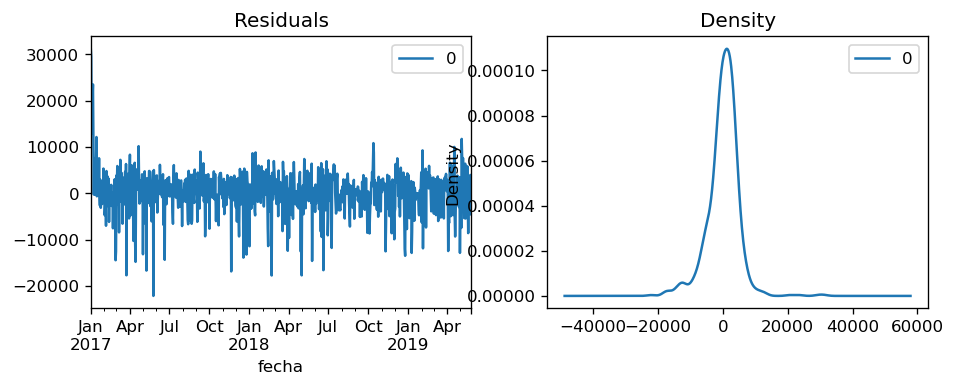

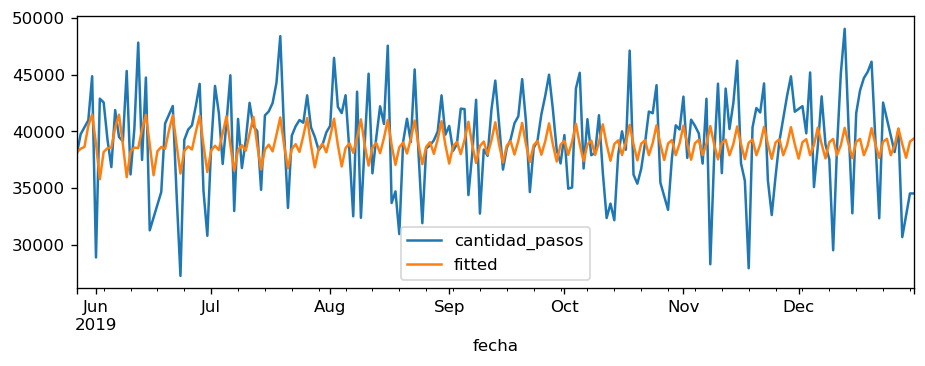

In [44]:
# Illia
test_forecast(model_illia_fit,periodos,illia_test)

MAPE en Test: 0.06771350389247192


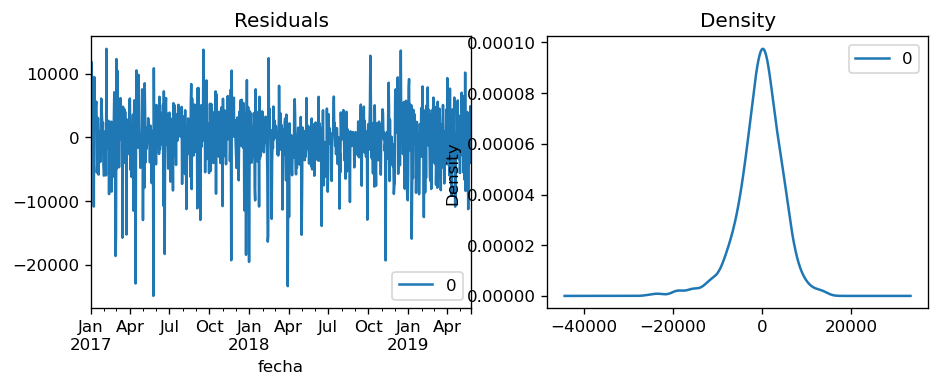

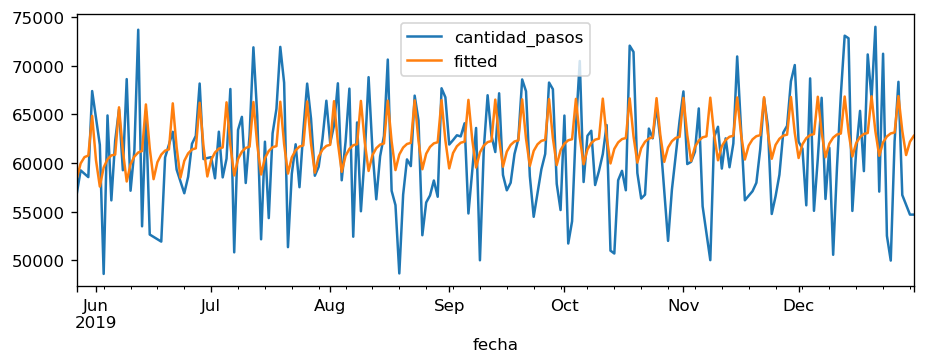

In [45]:
# Avellaneda
test_forecast(model_avellaneda_fit,periodos,avellaneda_test)

MAPE en Test: 0.0698927801812296


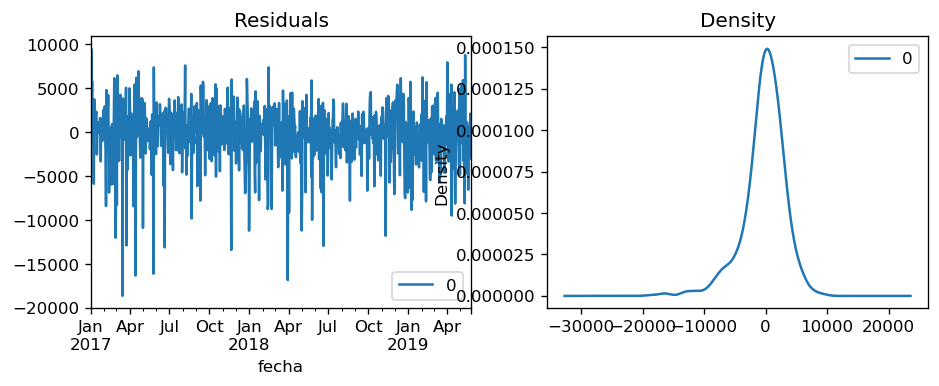

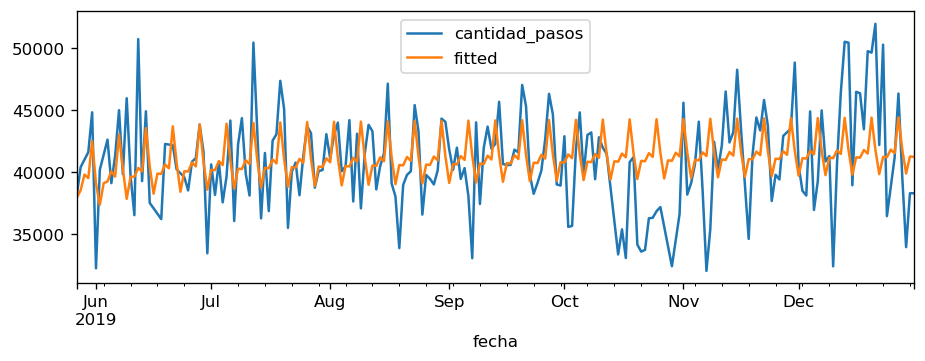

In [46]:
# Dellepiane
test_forecast(model_dellepiane_fit,periodos,dellepiane_test)

MAPE en Test: 0.19752224071357458


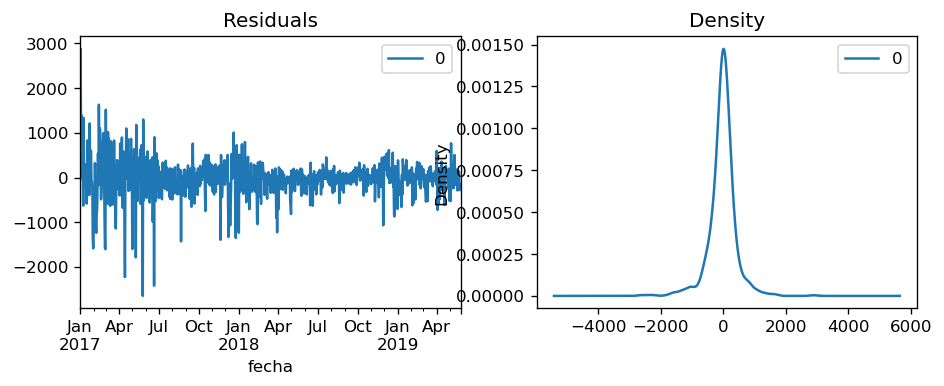

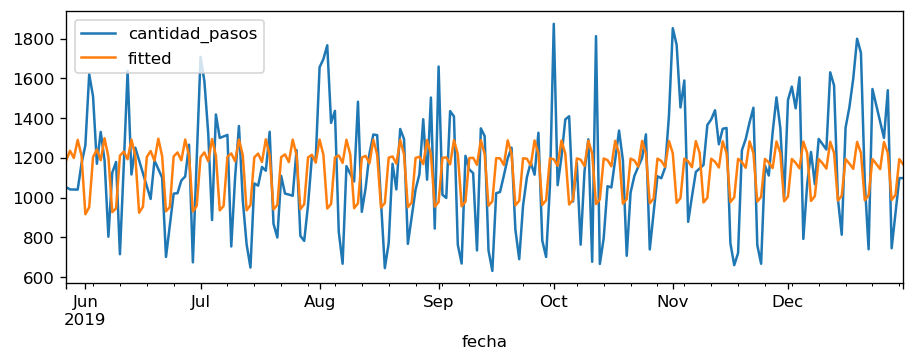

In [47]:
# Retiro
test_forecast(model_retiro_fit,periodos,retiro_test)

MAPE en Test: 0.10717018576286248


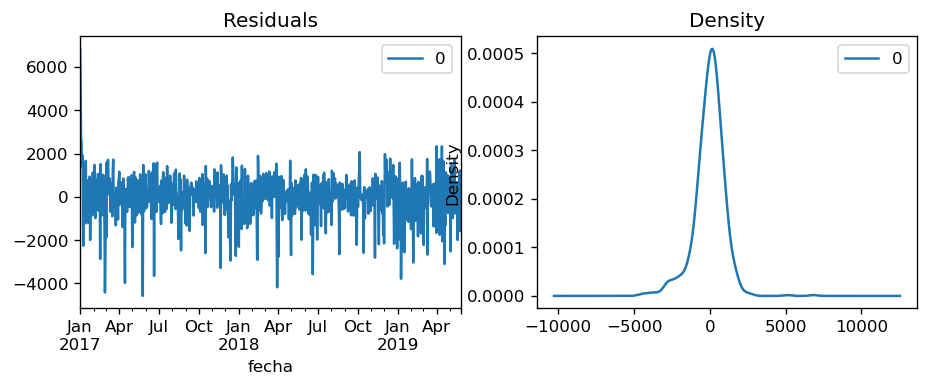

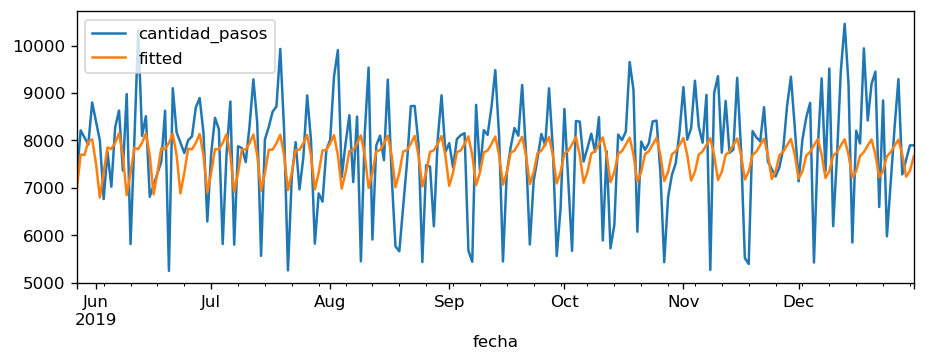

In [48]:
# Alberti
test_forecast(model_alberti_fit,periodos,alberti_test)

In [49]:
illia_pred = pd.DataFrame(model_illia_fit.forecast(periodos,alpha=0.05))
illia_pred.columns=["Illia"]

avellaneda_pred = pd.DataFrame(model_avellaneda_fit.forecast(periodos,alpha=0.05))
avellaneda_pred.columns=["Avellaneda"]

dellepiane_pred = pd.DataFrame(model_dellepiane_fit.forecast(periodos,alpha=0.05))
dellepiane_pred.columns=["Dellepiane"]

retiro_pred = pd.DataFrame(model_retiro_fit.forecast(periodos,alpha=0.05))
retiro_pred.columns=["Retiro"]

alberti_pred = pd.DataFrame(model_alberti_fit.forecast(periodos,alpha=0.05))
alberti_pred.columns=["Alberti"]

In [50]:
lista_df=[illia_pred,avellaneda_pred,dellepiane_pred,retiro_pred,alberti_pred]
Dataset_pred=pd.concat(lista_df, axis=1)

En todos los casos obtuvimos buenos valores de MAPE variando desde 6% hasta el 20%, lo cual es considerado una buena performance predictiva. Esto puede interpretarse como que en promedio el error absoluto que se va a cometer al predecir la cantidad de autos que circulen por día por una estación de peaje puede ser de 6% en algunas estaciones como Dellepiane o Avellaneda y en otros casos como en Retiro puede ascender hasta un 20%.

### Resultados

A continuación podemos ver en la tabla la cantidad predicha de autos que pagarán en efectivo cada día en cada una de las estaciones de peajes analizadas.

In [51]:
Dataset_pred

,Illia,Avellaneda,Dellepiane,Retiro,Alberti
2019-05-27,38148.470747,58402.801165,37956.151620,1186.100051,6955.673478
2019-05-28,38458.352854,59953.168389,38555.720132,1235.463474,7698.774198
2019-05-29,38632.964707,60601.128691,39818.026114,1198.970288,7691.101467
2019-05-30,40491.831965,60760.841073,39534.176824,1290.009580,7979.730434
2019-05-31,41471.142704,64839.789307,42505.836961,1211.252672,8019.200810
...,...,...,...,...,...
2019-12-27,40248.321195,66873.668287,44424.521445,1224.757743,8012.987938
2019-12-28,38873.982179,63305.233043,41850.615847,988.486331,7697.929471
2019-12-29,37672.267408,60816.968599,39898.595728,1013.113207,7233.984358
2019-12-30,39092.382906,62179.494409,41275.003373,1193.258152,7354.362155


Esta información puede ser utilizada por la empresa a cargo de estas estaciones de peaje para poder alocar mejor sus recursos humanos. A modo de ejemplo, haremos algunos cálculos para demostrar una posible manera de realizar este análisis. La información sobre el tiempo que demora un auto en pagar en efectivo en una cabina de peaje es un tiempo de referencia estimado tomado del trabajo final de AILÁN, Julián "Estimación de tiempos de espera en peajes" del ITBA (Instituto Tecnológico de Buenos Aires) presentado para la obtención del título de especialista en ciencia de datos.

Datos a tener en cuenta:
- Cantidad de minutos por día = 1440 min (24 hs * 60 min/hs)
- Demora estimada de pago de peaje en efectivo = 0.5 min (30s)

Entonces si dividimos la cantidad de autos pronosticada por día en la cantidad de minutos disponibles por día, conoceremos el promedio de autos por minuto que pagarán en efectivo en ese peaje (dejaremos de lado en esta ocasión, el hecho de el flujo de autos es distinto a cada hora del día).

$ Autospormin = \frac {y_{pred} [\frac{autos}{día}]}{1440 [\frac{minutos}{día}]} = autos [\frac{autos}{minuto}] $

$ Cabinas = Autospormin [\frac{autos}{min}] * 0.5 [\frac{\frac{minutos}{auto}}{cabina}] = cabinas [cabinas] $


In [52]:
illia_pred["Autospormin"]=illia_pred["Illia"]/1440
illia_pred["Cabinas"]=illia_pred["Autospormin"]*0.5

avellaneda_pred["Autospormin"]=avellaneda_pred["Avellaneda"]/1440
avellaneda_pred["Cabinas"]=avellaneda_pred["Autospormin"]*0.5

dellepiane_pred["Autospormin"]=dellepiane_pred["Dellepiane"]/1440
dellepiane_pred["Cabinas"]=dellepiane_pred["Autospormin"]*0.5

retiro_pred["Autospormin"]=retiro_pred["Retiro"]/1440
retiro_pred["Cabinas"]=retiro_pred["Autospormin"]*0.5

alberti_pred["Autospormin"]=alberti_pred["Alberti"]/1440
alberti_pred["Cabinas"]=alberti_pred["Autospormin"]*0.5

In [53]:
illia_pred

,Illia,Autospormin,Cabinas
2019-05-27,38148.470747,26.491994,13.245997
2019-05-28,38458.352854,26.707189,13.353595
2019-05-29,38632.964707,26.828448,13.414224
2019-05-30,40491.831965,28.119328,14.059664
2019-05-31,41471.142704,28.799405,14.399702
...,...,...,...
2019-12-27,40248.321195,27.950223,13.975112
2019-12-28,38873.982179,26.995821,13.497910
2019-12-29,37672.267408,26.161297,13.080648
2019-12-30,39092.382906,27.147488,13.573744


In [54]:
avellaneda_pred

,Avellaneda,Autospormin,Cabinas
2019-05-27,58402.801165,40.557501,20.278750
2019-05-28,59953.168389,41.634145,20.817072
2019-05-29,60601.128691,42.084117,21.042059
2019-05-30,60760.841073,42.195029,21.097514
2019-05-31,64839.789307,45.027631,22.513816
...,...,...,...
2019-12-27,66873.668287,46.440047,23.220024
2019-12-28,63305.233043,43.961967,21.980984
2019-12-29,60816.968599,42.234006,21.117003
2019-12-30,62179.494409,43.180204,21.590102


In [55]:
dellepiane_pred

,Dellepiane,Autospormin,Cabinas
2019-05-27,37956.151620,26.358439,13.179219
2019-05-28,38555.720132,26.774806,13.387403
2019-05-29,39818.026114,27.651407,13.825704
2019-05-30,39534.176824,27.454289,13.727145
2019-05-31,42505.836961,29.517942,14.758971
...,...,...,...
2019-12-27,44424.521445,30.850362,15.425181
2019-12-28,41850.615847,29.062928,14.531464
2019-12-29,39898.595728,27.707358,13.853679
2019-12-30,41275.003373,28.663197,14.331598


In [56]:
retiro_pred

,Retiro,Autospormin,Cabinas
2019-05-27,1186.100051,0.823681,0.411840
2019-05-28,1235.463474,0.857961,0.428980
2019-05-29,1198.970288,0.832618,0.416309
2019-05-30,1290.009580,0.895840,0.447920
2019-05-31,1211.252672,0.841148,0.420574
...,...,...,...
2019-12-27,1224.757743,0.850526,0.425263
2019-12-28,988.486331,0.686449,0.343224
2019-12-29,1013.113207,0.703551,0.351775
2019-12-30,1193.258152,0.828651,0.414326


In [57]:
alberti_pred

,Alberti,Autospormin,Cabinas
2019-05-27,6955.673478,4.830329,2.415164
2019-05-28,7698.774198,5.346371,2.673185
2019-05-29,7691.101467,5.341043,2.670521
2019-05-30,7979.730434,5.541479,2.770740
2019-05-31,8019.200810,5.568889,2.784445
...,...,...,...
2019-12-27,8012.987938,5.564575,2.782287
2019-12-28,7697.929471,5.345784,2.672892
2019-12-29,7233.984358,5.023600,2.511800
2019-12-30,7354.362155,5.107196,2.553598


De esta manera se podría tener un cálculo general de cuántas cabinas para pago en efectivo necesitaríamos tener disponibles por día (en ambos sentidos) en cada peaje, considerando que no se quiere hacer esperar a los conductores.
El trabajo podría ampliarse aplicando esta misma metodología a una frecuencia horaria, para tener un mayor detalle y poder hacer cambios y ajustes más finos.